***Mount Google Drive:***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


***Configure Enviroment:***

***Download Dataset:***

In [3]:
!kaggle datasets download -d tientd95/fitrec-dataset

 99% 1.87G/1.88G [00:23<00:00, 70.8MB/s]
100% 1.88G/1.88G [00:23<00:00, 85.8MB/s]


***Extract Zip File:***

In [4]:
from zipfile import ZipFile
file_name="/content/fitrec-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# ***1. Initialize pyspark framework and load data into pyspark's dataframe:***
*   This data is about calculating the heart rate of people, along with other relating features such as: gender, weather condition, sport type, GPS, etc..

Sourced from:
https://sites.google.com/eng.ucsd.edu/fitrec-project/home



In [6]:
# Imports
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats

# Helps Autoprint items
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [7]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'

# Initialize a spark session
conf = pyspark.SparkConf().setMaster("local[*]") \
          .set('spark.executot.heatbeatInterval', 1000) \
          .set('spark.network.timeout', 1000) \
          .set('spark.core.connection.ack.wait.timeout', '3600') \
          .set('spark.executor.memory', MAX_MEMORY) \
          .set('spark.driver.memory', MAX_MEMORY)

def init_spark():
  spark = SparkSession.builder.appName('Pyspark_guide').config(conf=conf) \
        .getOrCreate()
  return spark

spark = init_spark()
filename_data = '/content/endomondoHR.json'

# Load the main dataset into pyspark DataFrame
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# ***2. Overview of Dataset***

***Schema, columns and datatypes of the dataset:***

The data set has both single value columns (int, str) and columns made of arrays/list.

In [8]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Columns overview


Column Name      Data type
0     altitude  array<double>
1       gender         string
2   heart_rate  array<bigint>
3           id         bigint
4     latitude  array<double>
5    longitude  array<double>
6        speed  array<double>
7        sport         string
8    timestamp  array<bigint>
9          url         string
10      userId         bigint

In [9]:
print("Data frame describe (str and numeric columns only): ")
df.describe().toPandas()
print(f'There are a total of {df.count()} rows, Print the first 2 data rows: ')
df.limit(2).toPandas()

Data frame describe (str and numeric columns only): 


summary   gender                   id     sport  \
0   count   253020               253020    253020   
1    mean     None  3.566244412926132E8      None   
2  stddev     None  1.574845634895318E8      None   
3     min   female                99296  aerobics   
4     max  unknown            674008008      yoga   

                                                 url              userId  
0                                             253020              253020  
1                                               None   4619648.939783417  
2                                               None  3932877.7296880507  
3  https://www.endomondo.com/users/10014612/worko...                  69  
4  https://www.endomondo.com/users/9991401/workou...            15481421

There are a total of 253020 rows, Print the first 2 data rows: 


altitude gender  \
0  [41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....   male   
1  [38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....   male   

                                          heart_rate         id  \
0  [100, 111, 120, 119, 120, 116, 125, 128, 131, ...  396826535   
1  [100, 105, 111, 110, 108, 115, 126, 130, 132, ...  392337038   

                                            latitude  \
0  [60.173348765820265, 60.173239801079035, 60.17...   
1  [60.173247596248984, 60.17320962622762, 60.172...   

                                           longitude  \
0  [24.64977040886879, 24.65014273300767, 24.6509...   
1  [24.649855233728886, 24.65015547350049, 24.650...   

                                               speed sport  \
0  [6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...  bike   
1  [9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...  bike   

                                           timestamp  \
0  [1408898746, 1408898754, 1408898765, 140889877...   
1  [1408221682, 1408221687, 1408221699, 140822170...   

                                                 url    userId  
0  https://www.endomondo.com/users/10921915/worko...  10921915  
1  https://www.endomondo.com/users/10921915/worko...  10921915

# ***3. Detect missing values and abnormal zeros***



*   string columns, check for None and null
*   numeric columns, check for zeros and NAN
*   arrays type columns, check if the array contains zeros or NAN




In [10]:
print("Column overview")
pd.DataFrame(df.dtypes, columns = ['Column Name', 'Data type'])


Column overview


Column Name      Data type
0     altitude  array<double>
1       gender         string
2   heart_rate  array<bigint>
3           id         bigint
4     latitude  array<double>
5    longitude  array<double>
6        speed  array<double>
7        sport         string
8    timestamp  array<bigint>
9          url         string
10      userId         bigint

In [11]:
string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id', 'userId']
array_columns = ['altitude', 'heart_rate', 'latitude',
                 'longitude', 'speed', 'timestamp']
"""
check string columns with None and Null values

missing_count = df.filter(col(column.eqNullSafe(None) |
col(column).isNull().count()))

missing_values.update({column: missing_count})
"""
missing_values = {}
for index, column in enumerate(df.columns):
  if column in string_columns:
    missing_count = df.filter(col(column).eqNullSafe(None) |
                              col(column).isNull()).count()
    missing_values.update({column:missing_count})

# check zeros, None, NaN
  if column in numeric_columns:
    missing_count = df.where(col(column).isin([0, None, np.nan])).count()
    missing_values.update({column:missing_count})

# check zeros and NaN
  if column in array_columns:
    missing_count = df.filter(array_contains(df[column], 0) |
                              array_contains(df[column], np.nan)).count()
    missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

'\ncheck string columns with None and Null values\n\nmissing_count = df.filter(col(column.eqNullSafe(None) |\ncol(column).isNull().count()))\n\nmissing_values.update({column: missing_count})\n'

altitude  gender  heart_rate  id  latitude  longitude  speed  sport  \
0     40848       0        1280   0       113        113   7741      0   

   timestamp  url  userId  
0          0    0       0

In [12]:
"""
create new column to count number of timestamps recorded per row/workout,
named as 'PerWorkoutRecordCount' column
"""

df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))

# This part is written as a function to be used again later
def user_activity_workout_summarize(df):
  user_count = format(df.select('userId').distinct().count(), ',d')
  workout_count = format(df.select('Id').distinct().count(), ',d')
  activity_count = str(df.select('sport').distinct().count())
  sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
  total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0], ',d')
  columns = ['Users count', 'Activity types count',
             'Workouts count', 'Total records count']
  data = [[user_count], [activity_count],
   [workout_count], [total_records_count]]
  sum_dict = {column: data[i] for i, column in enumerate(columns)}
  sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
  gender_user_count = df.select(
      'gender', 'userId').distinct().groupBy(
          'gender').count().toPandas()
  gender_activities_count = df.groupBy('gender').count().toPandas()
  gender_user_activity_count = gender_user_count.join(
      gender_activities_count.set_index('gender'), on='gender',
                                      how='inner',lsuffix='_gu')

  gender_user_activity_count.columns = ['Gender',
                                        '# of users',
                                        'Activities (workouts) count']
  return sum_df, gender_user_activity_count

sum_dfs = user_activity_workout_summarize(df)
print('\nOverall data set summary on users, workouts and numbers of records (pre-filtering):')
sum_dfs[0]

"\ncreate new column to count number of timestamps recorded per row/workout,\nnamed as 'PerWorkoutRecordCount' column\n"


Overall data set summary on users, workouts and numbers of records (pre-filtering):


Users count Activity types count Workouts count Total records count
0       1,104                   49        253,020         111,541,956

In [13]:
print('Number of workouts that have less than 50 records and statistic summary: ')
removed_df = df.select(
    'PerWorkoutRecordCount').where(
      df.PerWorkoutRecordCount<50).toPandas().describe().astype(int)
removed_df.rename(
    columns = {'PerWorkoutRecordCount' : 'PerWorkoutRecordCount<50'},
    inplace=True)
removed_df.T

Number of workouts that have less than 50 records and statistic summary: 


count  mean  std  min  25%  50%  75%  max
PerWorkoutRecordCount<50   5541    23   14    1   11   22   36   49

4. Pyspark lazy evaluation

[Lazy evaluation](https://towardsdatascience.com/3-reasons-why-sparks-lazy-evaluation-is-useful-ed06e27360c4) enhances the power of Apache Spark by reducing the execution time of the RDD operations(Resilient Distributed Dataset). We can simply remember that all precessing in Pyspark is abstration. When we want to return the results, actually we tell Spark what is the eventual answer you're interested in and it figures out the best way to get there. As a result, it optimizes the performance and achieves fault tolerance.

In order to see the result, we have to call Spark.collect().

Normally, we can show the results with syntax:
*   df.take(k)
*   df.limit(k)

to get the results with k row.

When k becomes a larger number the two ways above take longer to complete the process, because this syntax above did not utilize the power of Pyspark processing (lazy evaluatio). In order to utiize this quick process, we should use:

*   df.collect()[:k}

to return the k row as we wish.







In [14]:
ranked_sport_users_df = df.select(df.sport, df.userId) \
      .distinct() \
      .groupBy(df.sport) \
      .count() \
      .orderBy("count", ascending=False)

# Top 5 workout types
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()

#Rename column name: 'count' --> Users count
highest_sport_users_df.rename(columns={'count':'Users count'}, inplace=True)

# Calulate the total users
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

In [15]:
ranked_sport_users_df.collect()[:5]

[Row(sport='run', count=865),
 Row(sport='bike', count=794),
 Row(sport='mountain bike', count=336),
 Row(sport='bike (transport)', count=252),
 Row(sport='walk', count=209)]

# ***5. Exploratory Data Analysis***

chart indice the top 5 workout types as we evaluated above:

Top 5 sports that have the most users participated: 


<ipython-input-16-50ab2d6da59f>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(


sport  Users count  percentage
0               run          865   25.130738
1              bike          794   23.067984
2     mountain bike          336    9.761766
3  bike (transport)          252    7.321325
4              walk          209    6.072051
5            others          986   28.646136

<ipython-input-16-50ab2d6da59f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(


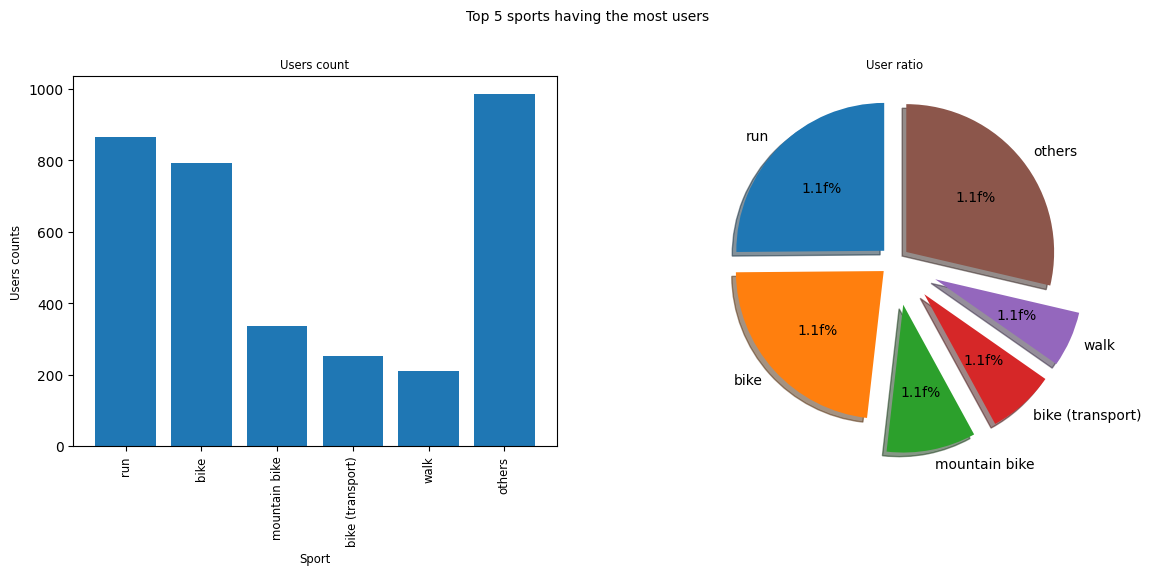

In [16]:
highest_sport_users_df_renamed = highest_sport_users_df

# Compute the percentage of top 5 workout type / total users
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count']  \
                                              / total_sports_users * 100

# Assign the rest of users belonging to another specific group that we call 'others'
others = {
    'sport' : 'others',
    'Users count' : total_sports_users - sum(
        highest_sport_users_df_renamed['Users count']),
    'percentage' : 100 - sum(highest_sport_users_df_renamed['percentage'])
}

highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(
    others, ignore_index=True
)

print('Top 5 sports that have the most users participated: ')
highest_sport_users_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_sport_users_df_renamed['sport'],
                   height=highest_sport_users_df_renamed['Users count'])
title0 = axs[0].set_title('Users count', fontsize='small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Users counts', fontsize='small')
xsticks_label = axs[0].set_xticklabels(
    highest_sport_users_df_renamed['sport'],
    rotation='vertical',
    fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)

title1 = axs[1].set_title('User ratio', fontsize='small')
plot1 = axs[1].pie(
    x=highest_sport_users_df_renamed['percentage'],
    labels=highest_sport_users_df_renamed['sport'],
    autopct='1.1f%%', shadow=True, explode=explode,
    startangle=90, radius=1
)
text = fig.text(0.5, 1.02, 'Top 5 sports having the most users',
                ha='center',
                va='top',
                transform=fig.transFigure)

As the data shows: running, walking, and biking-related activities are the most spend by users, which is quite reasonable due to the convenience without much investment.

In [17]:
# Quick oveview of activities by gender
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
activities_by_gender[:5]

sport  gender   count
0                   hiking  female      71
1  core stability training    male    1103
2                      run    male  107882
3                 kayaking    male     253
4            mountain bike    male   12782

# ***6. Unstack Pyspark DataFrame***

Reshape the table to flatten the gender column so that we can begin visualization.

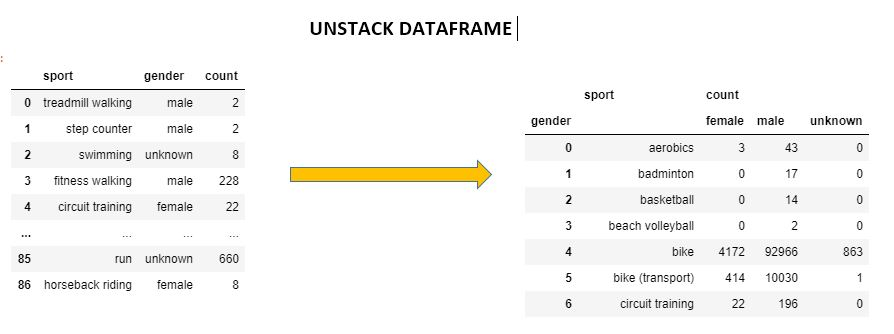

To reshape the table like this, we use:

In [18]:
# df.unstack()

There are total: 49  activities and here is a chart for activities based on gender: 


<ipython-input-19-58f1c8373a1f>:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  level=0).apply(lambda x: 100 * x / x.sum(


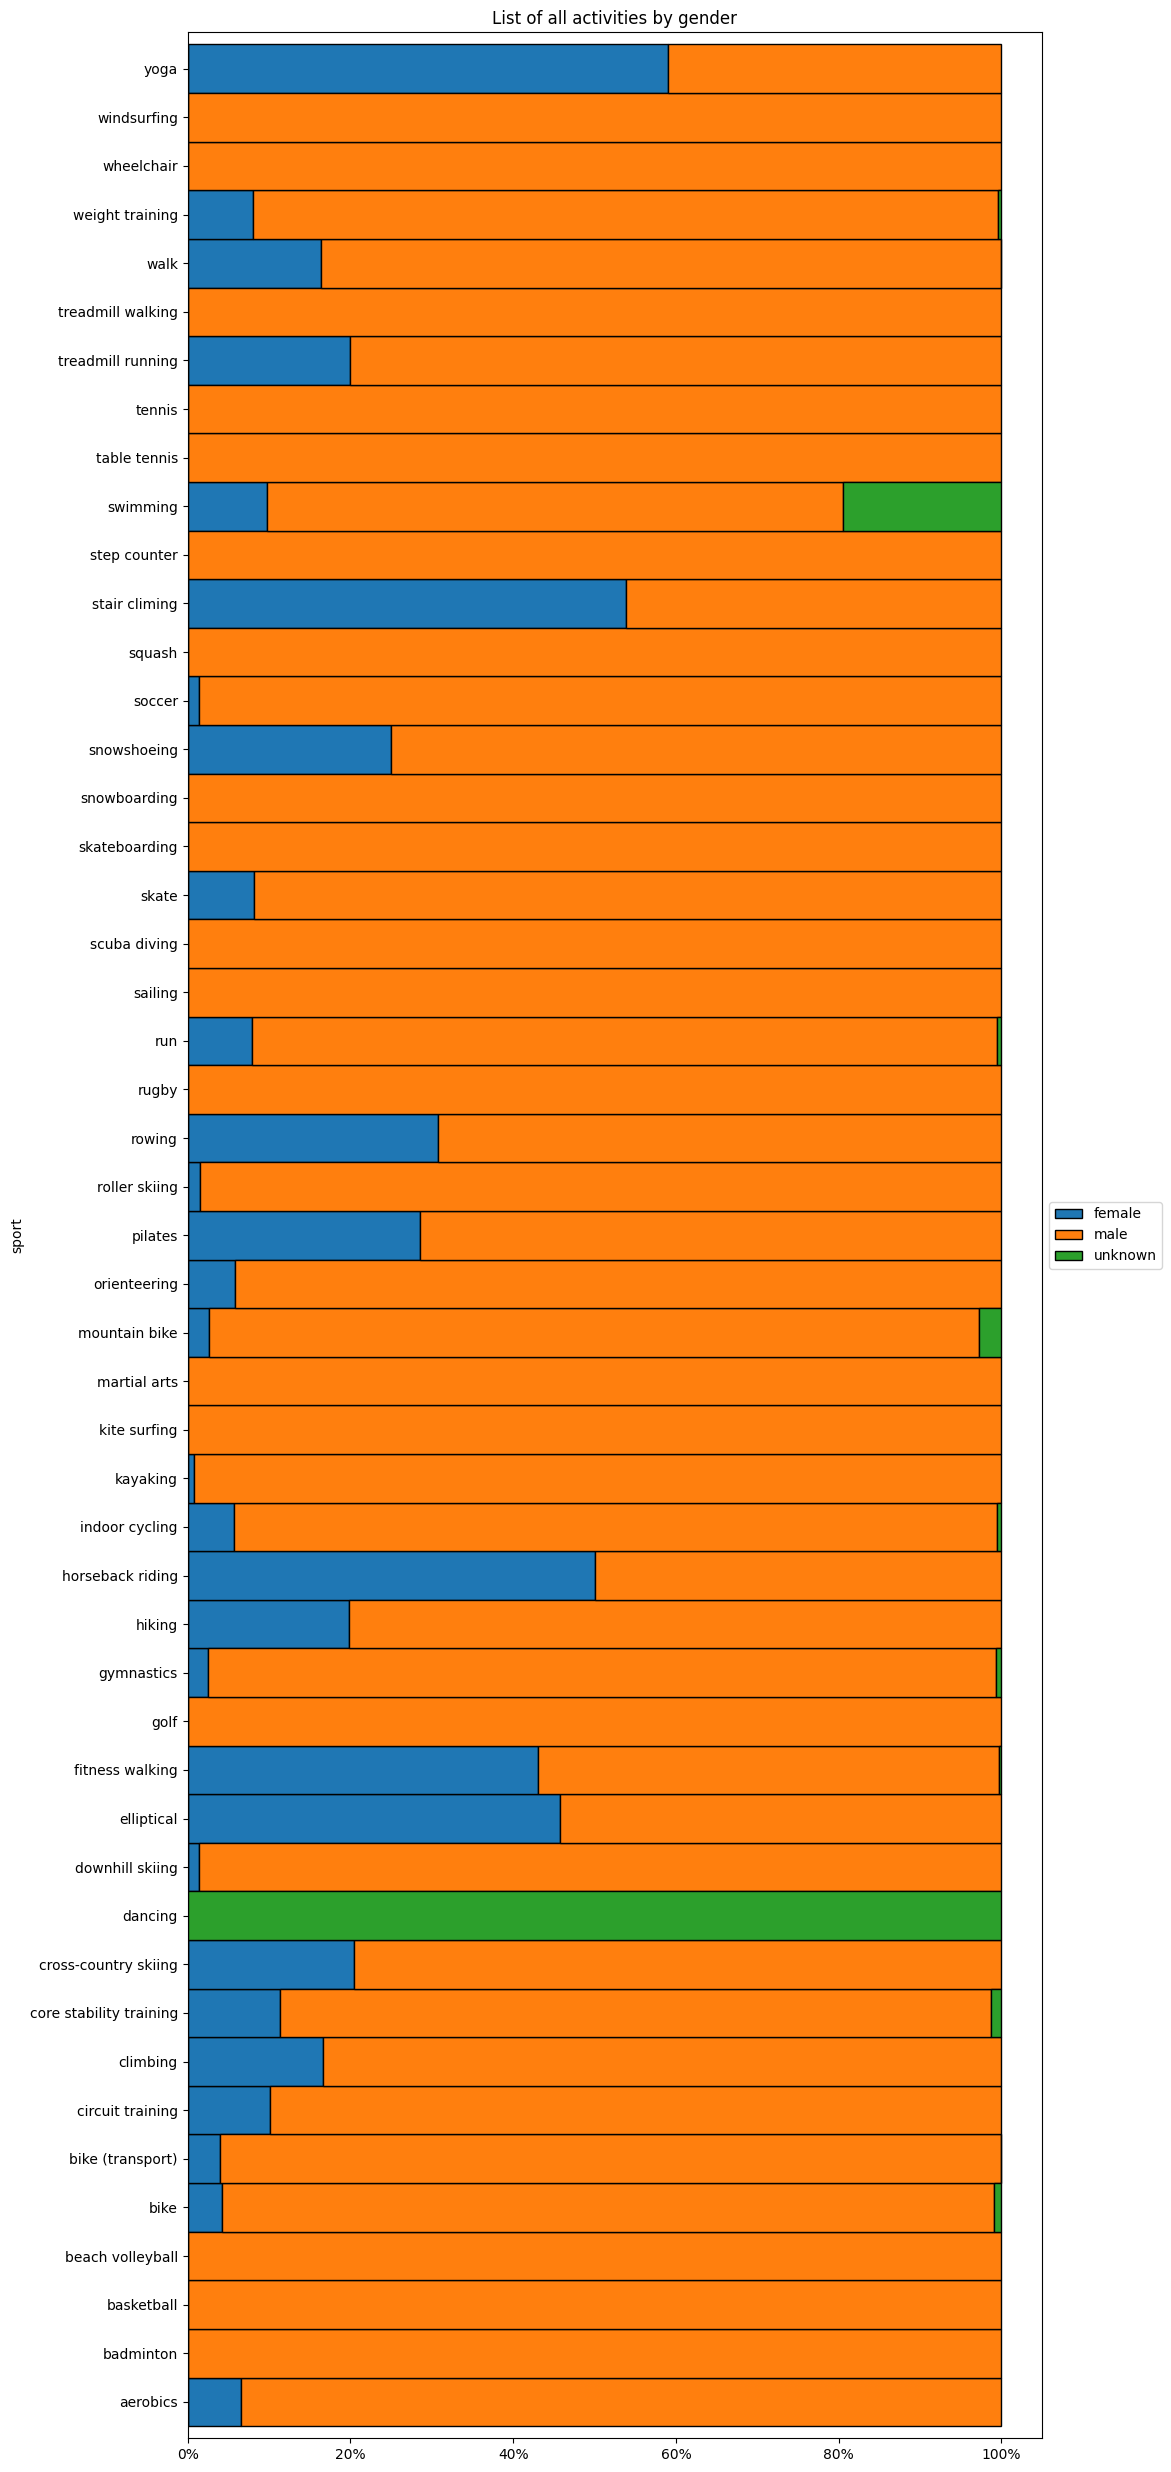

In [19]:
total_activities = ranked_sport_users_df.count()
print(f'There are total: {total_activities} \
 activities and here is a chart for activities based on gender: ')

# Add the info for activities based on gender
activities_by_gender = df.groupBy('sport','gender').count().toPandas()

# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1, 1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1,
                      rowspan=1)
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(
        level=0).apply(lambda x: 100 * x / x.sum(
        )).unstack(   # Apply .unstack to Reshape Data
        ).plot(
        kind='barh',stacked=True, width=1, edgecolor='black', ax=ax,
        title='List of all activities by gender'
    );
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()),
    loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
# percent formatter: Determines how the number is converted into a percentage.
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

In [20]:
df['UserId']

Column<'UserId'>

<ipython-input-21-60ca1c3f28fd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_activities_by_gender_df = top_activities_by_gender_df.append(


sport  female    male  unknown   total  percentage
0               run    9360  107882      660  117902   46.597897
1              bike    4172   92966      863   98001   38.732511
2     mountain bike     353   12782      375   13510    5.339499
3  bike (transport)     414   10030        1   10445    4.128132
5            others    1034    8255       42    9331    3.687851
4              walk     626    3204        1    3831    1.514110

<ipython-input-21-60ca1c3f28fd>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport'],


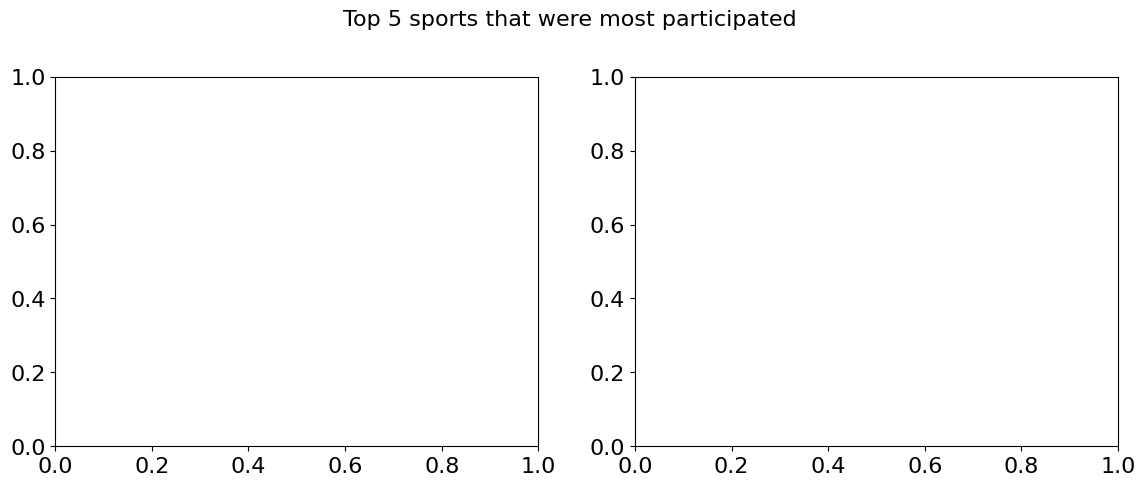

In [21]:
# Top pareto of 5 sports that have the most participation
activities_by_gender_df = activities_by_gender.pivot_table(
    index="sport", columns="gender", values='count', fill_value=0) \
    .reset_index().rename_axis(None, axis=1)

activities_by_gender_df['total'] = activities_by_gender_df['male'] \
        + activities_by_gender_df['female'] \
        + activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = activities_by_gender_df['total'] \
    / sum(activities_by_gender_df['total']) * 100
top_activities_by_gender_df = activities_by_gender_df.sort_values(
    by='percentage', ascending=False
).head(5)

others = {'sport' : 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = sum(activities_by_gender_df[column]) - sum(top_activities_by_gender_df[column])
    others.update({column: value})
top_activities_by_gender_df = top_activities_by_gender_df.append(
    others, ignore_index=True
)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(
    by='percentage', ascending=False
)
top_activities_by_gender_df

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))
plot0 = axs[0].bar(x=top_activities_by_gender_df['sport'],
                   height=top_activities_by_gender_df['total'])
title0 = axs[0].set_title('Workout count', fontsize='small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Workout Count (times)', fontsize='small')
xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport'],
                                       rotation='vertical',
                                       fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout Ratio', fontsize='small')
plot1 = axs[1].pie(
    x=top_activities_by_gender_df['percentage'],
    labels=top_activities_by_gender_df['sport'],
    autopct='1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated',
                ha='center', va='top', transform=fig.transFigure)

Similar to the user participation, running. walking, and biking are also the dominant contribution interm of number of workout counts. The only difference is that pure running and biking activities count is much bigger than those of the remaining sports, and the total count of those 2 already take up more than 85% of total activities.

In [22]:
df.userId

Column<'userId'>

In [23]:
# Question 1: How many people participated in more than 1 sport

min_number_of_sport = 1

sport_df = df.select(df.userId, df.gender, df.sport).distinct().groupBy(
    df.userId, df.gender
    ).count(
    )

user_more_sports_df = sport_df.filter(sport_df['count'] > min_number_of_sport
    ).orderBy(
        "count", ascending=False
    ).toPandas(
    )

user_more_sports_df.rename(columns = {'count': 'Sports count'}, inplace=True)
user_more_sports_df.describe().astype(int).T

count     mean      std  min      25%      50%      75%  \
userId          822  4860464  3953412   69  1609606  3730685  7554937   
Sports count    822        3        2    2        2        3        5   

                   max  
userId        15481421  
Sports count        16

Based on the summary, there are 822 persons participated in more than 1 sport.

Among them in average, a person takes part in about 3 sports and there are some people playing up-to 16 sports.

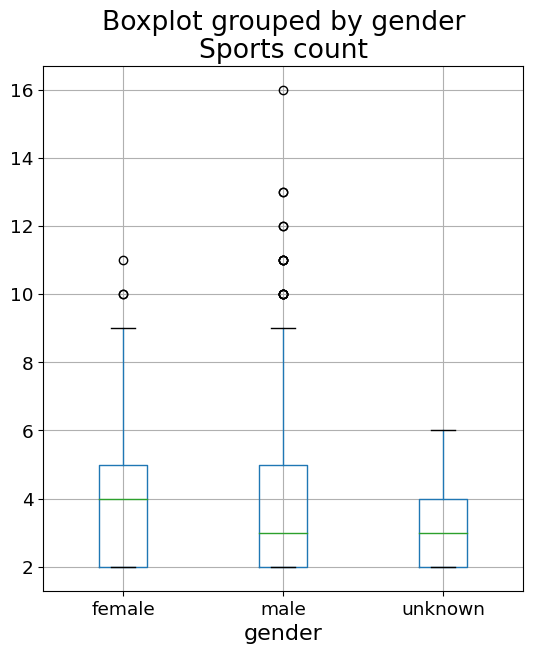

In [24]:
# Gender in box plot
plot = user_more_sports_df.boxplot(column='Sports count', by='gender',
                                   fontsize='small', figsize=(6, 7))

The box plot showed that except the outliers, both male and females have nearly the same distribution of sports participation.

***Distribution of records count per workout***

For a more detailed observation, we break down the record count per activity into each individual sport. Based on the distribution, the maximum records per workout is 500, but not all workouts and sport types reach that specified number.


Plot of workouts distribution by activity type: 


<ipython-input-25-dcec59396098>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  PerWorkoutRecordCount_dist = df.select(


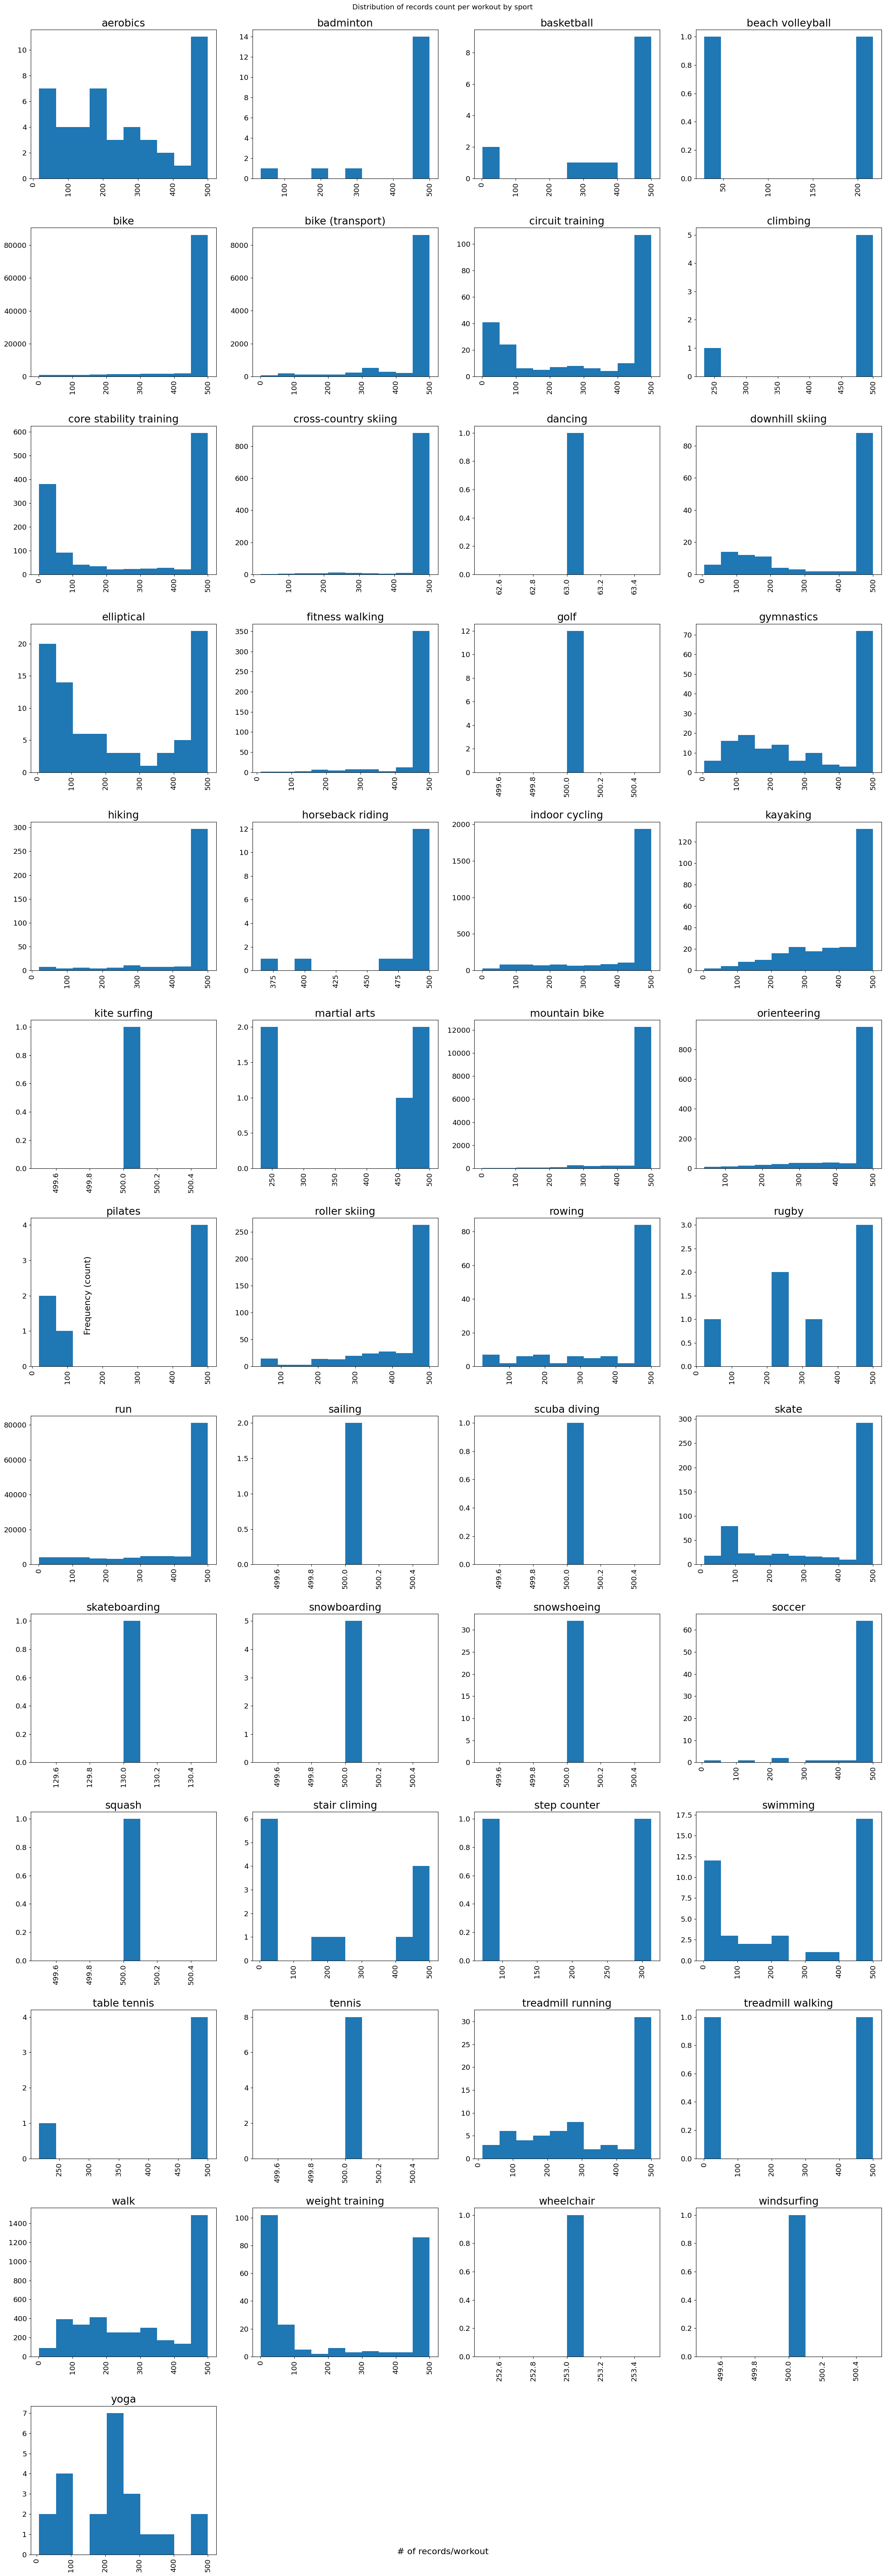

In [25]:
print('\nPlot of workouts distribution by activity type: ')
plot_size_x, plot_size_y = 5, 5
fig_size_x, fig_size_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize = (fig_size_x, fig_size_y)
fig = plt.figure(figsize=figsize)
grid_size = (13, 4)
ax = plt.subplot2grid(grid_size, (0, 0), colspan=1, rowspan=1)

PerWorkoutRecordCount_dist = df.select(
    'PerWorkoutRecordCount', 'sport').toPandas().hist(
        column='PerWorkoutRecordCount', bins=10, sharex=False, grid=True,
        xlabelsize='small', ylabelsize='small', by='sport',ax=ax,
        layout=grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of records count per workout by sport',
                 ha='center', fontsize='small', transform=fig.transFigure);
xlabel = fig.text(0.5, 0.01, '# of records/workout',
                  va='bottom', ha='center', transform=fig.transFigure);
ylabel = fig.text(0.1, 0.5, 'Frequency (count)',
                  va='center', rotation='vertical');


In [26]:
# Filter df with at least 10 records (as we are assuming if any user_id
# with less then 10 records would not be meaningful
qualified_df = df \
      .select(df.sport, df.userId, df.gender) \
      .groupby(df.sport, df.userId, df.gender) \
      .count()
qualified_df = qualified_df.filter(qualified_df['count'] >= 10) \
      .orderBy('count', ascending=False)

In [27]:
print('Number of users having more than 10 workouts: ')
qualified_pd_df = qualified_df.select('userId', 'gender').distinct() \
                              .groupBy(qualified_df.gender).count().toPandas()
qualified_pd_df.rename(columns={'count': 'User count'}, inplace=True)
qualified_pd_df
qualified_users_count = sum(qualified_pd_df['User count'])
total_users_count = df.select('userId').distinct().count()
qualified_percentage = round((
    qualified_users_count / total_users_count), 2) * 100
print('\nSo there is {} / {} of users qualifiying the 10 historical recods criteria, which is {:.2f}' \
      .format(qualified_users_count, total_users_count, qualified_percentage))

Number of users having more than 10 workouts: 


gender  User count
0  unknown          13
1   female          88
2     male         886


So there is 987 / 1104 of users qualifiying the 10 historical recods criteria, which is 89.00


# ***7. Pyspark UDF Registering***

In short, Registering UDF to Pyspark is the process of turning python Functions into Pyspark Functions (UDF)

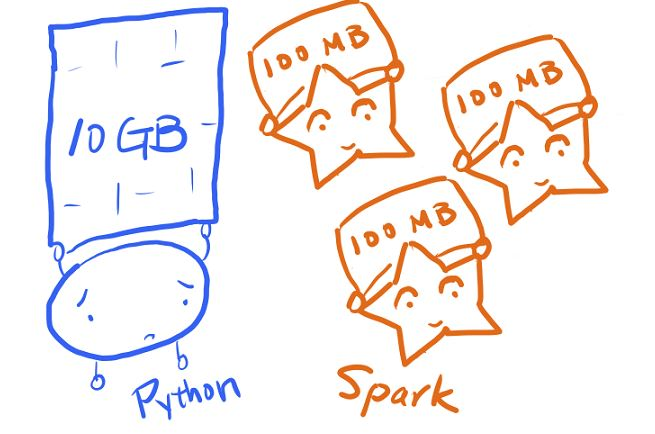

When we run the code on Spark clusters, this technique will speed up the process and save valuable exucute time.

To learn more about Pyspark UDF, you can visit: [Pyspark UDF](https://changhsinlee.com/pyspark-udf/)

We will start applying registring python function to UDF in the 'timestamp' column

This column is very important if we're using the dataset to predict something, like heart rate to detect bad signals. This is a type of timeseries analysis so we will look at the timestamp column carefully.

#**Creating some new features from:**
timestamp.

As seen before timestamp column contains records of timestamp series of a single workout (data row) and is stored in UNIZ timestamp format. To have more insights on this column, we will create 4 more new columns from it.

*   **date_time:** Convert UNIX timestamp into python's datetime format
*   **duration:** Total time of a single workout, in minute in order to ge the workout **duration**, we get the difference between max and min of datetime list of each workout
*   **workout_start_time:** it's the hour part of the first datetime record of a workout
*   **interval:** List of time lapses between each single timestamp record in a signel workout, in seconds
AND for **interval**, we will calculate it by taking the difference between 2 consecutive timestamp records within a workout

In order to attach these 4 features to SparkDataFrame, we register them with PYSPARK UDF





In [28]:
# function_to_udf = udf(function, Datatype())

# Datatype() can be floattype(), TimestampType(), etc

In [29]:
# Look again at the Timestamp Column
df.limit(3).toPandas()

altitude gender  \
0  [41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....   male   
1  [38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....   male   
2  [76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....   male   

                                          heart_rate         id  \
0  [100, 111, 120, 119, 120, 116, 125, 128, 131, ...  396826535   
1  [100, 105, 111, 110, 108, 115, 126, 130, 132, ...  392337038   
2  [99, 105, 113, 110, 109, 110, 108, 121, 116, 1...  389643739   

                                            latitude  \
0  [60.173348765820265, 60.173239801079035, 60.17...   
1  [60.173247596248984, 60.17320962622762, 60.172...   
2  [60.17326201312244, 60.173205351457, 60.172969...   

                                           longitude  \
0  [24.64977040886879, 24.65014273300767, 24.6509...   
1  [24.649855233728886, 24.65015547350049, 24.650...   
2  [24.64995657093823, 24.650197718292475, 24.651...   

                                               speed sport  \
0  [6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...  bike   
1  [9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...  bike   
2  [4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...  bike   

                                           timestamp  \
0  [1408898746, 1408898754, 1408898765, 140889877...   
1  [1408221682, 1408221687, 1408221699, 140822170...   
2  [1407858459, 1407858466, 1407858478, 140785849...   

                                                 url    userId  \
0  https://www.endomondo.com/users/10921915/worko...  10921915   
1  https://www.endomondo.com/users/10921915/worko...  10921915   
2  https://www.endomondo.com/users/10921915/worko...  10921915   

   PerWorkoutRecordCount  
0                    500  
1                    500  
2                    500

We create 4 helperfunctions for 'timestamp' column as described above then convert them to UDF

In [30]:
# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time',
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))


# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()

New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds)
, first 5 rows:


timestamp  \
0  [1408898746, 1408898754, 1408898765, 140889877...   
1  [1408221682, 1408221687, 1408221699, 140822170...   
2  [1407858459, 1407858466, 1407858478, 140785849...   
3  [1407432042, 1407432048, 1407432056, 140743206...   
4  [1406909434, 1406909436, 1406909437, 140690943...   

                                           date_time  workout_start_time  \
0  [2014-08-24 09:45:46, 2014-08-24 09:45:54, 201...                   9   
1  [2014-08-16 13:41:22, 2014-08-16 13:41:27, 201...                  13   
2  [2014-08-12 08:47:39, 2014-08-12 08:47:46, 201...                   8   
3  [2014-08-07 10:20:42, 2014-08-07 10:20:48, 201...                  10   
4  [2014-08-01 09:10:34, 2014-08-01 09:10:36, 201...                   9   

     duration                                           interval  
0  126.483330  [8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,...  
1   74.000000  [5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,...  
2  112.483330  [7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ...  
3   75.316666  [6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1...  
4   22.616667  [2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ...

Now, we look at the duration of each workout (in minutes)....

First some typical statistics.

In [31]:
print('\nLet''s look at the statistics of the new duration column (in minutes):')
df.select('duration').toPandas().describe().T


Lets look at the statistics of the new duration column (in minutes):


count       mean        std  min        25%        50%  \
duration  253020.0  84.486427  98.093048  0.0  32.166668  58.916668   

                75%          max  
duration  102.73333  1439.966675

From the statistic of the duration column, it can be observed that workout duration can last from 0 minutes and up to 1 full day (1440 minutes = 24 hours). The duration of 0 mights be for workouts that only have 1 single record, so the min and max timestamp would be the same.


Plotting distribution of duration per sport type:


<ipython-input-32-df3996d64f8a>:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  duration_dist = df.select('duration', 'sport').toPandas().hist(


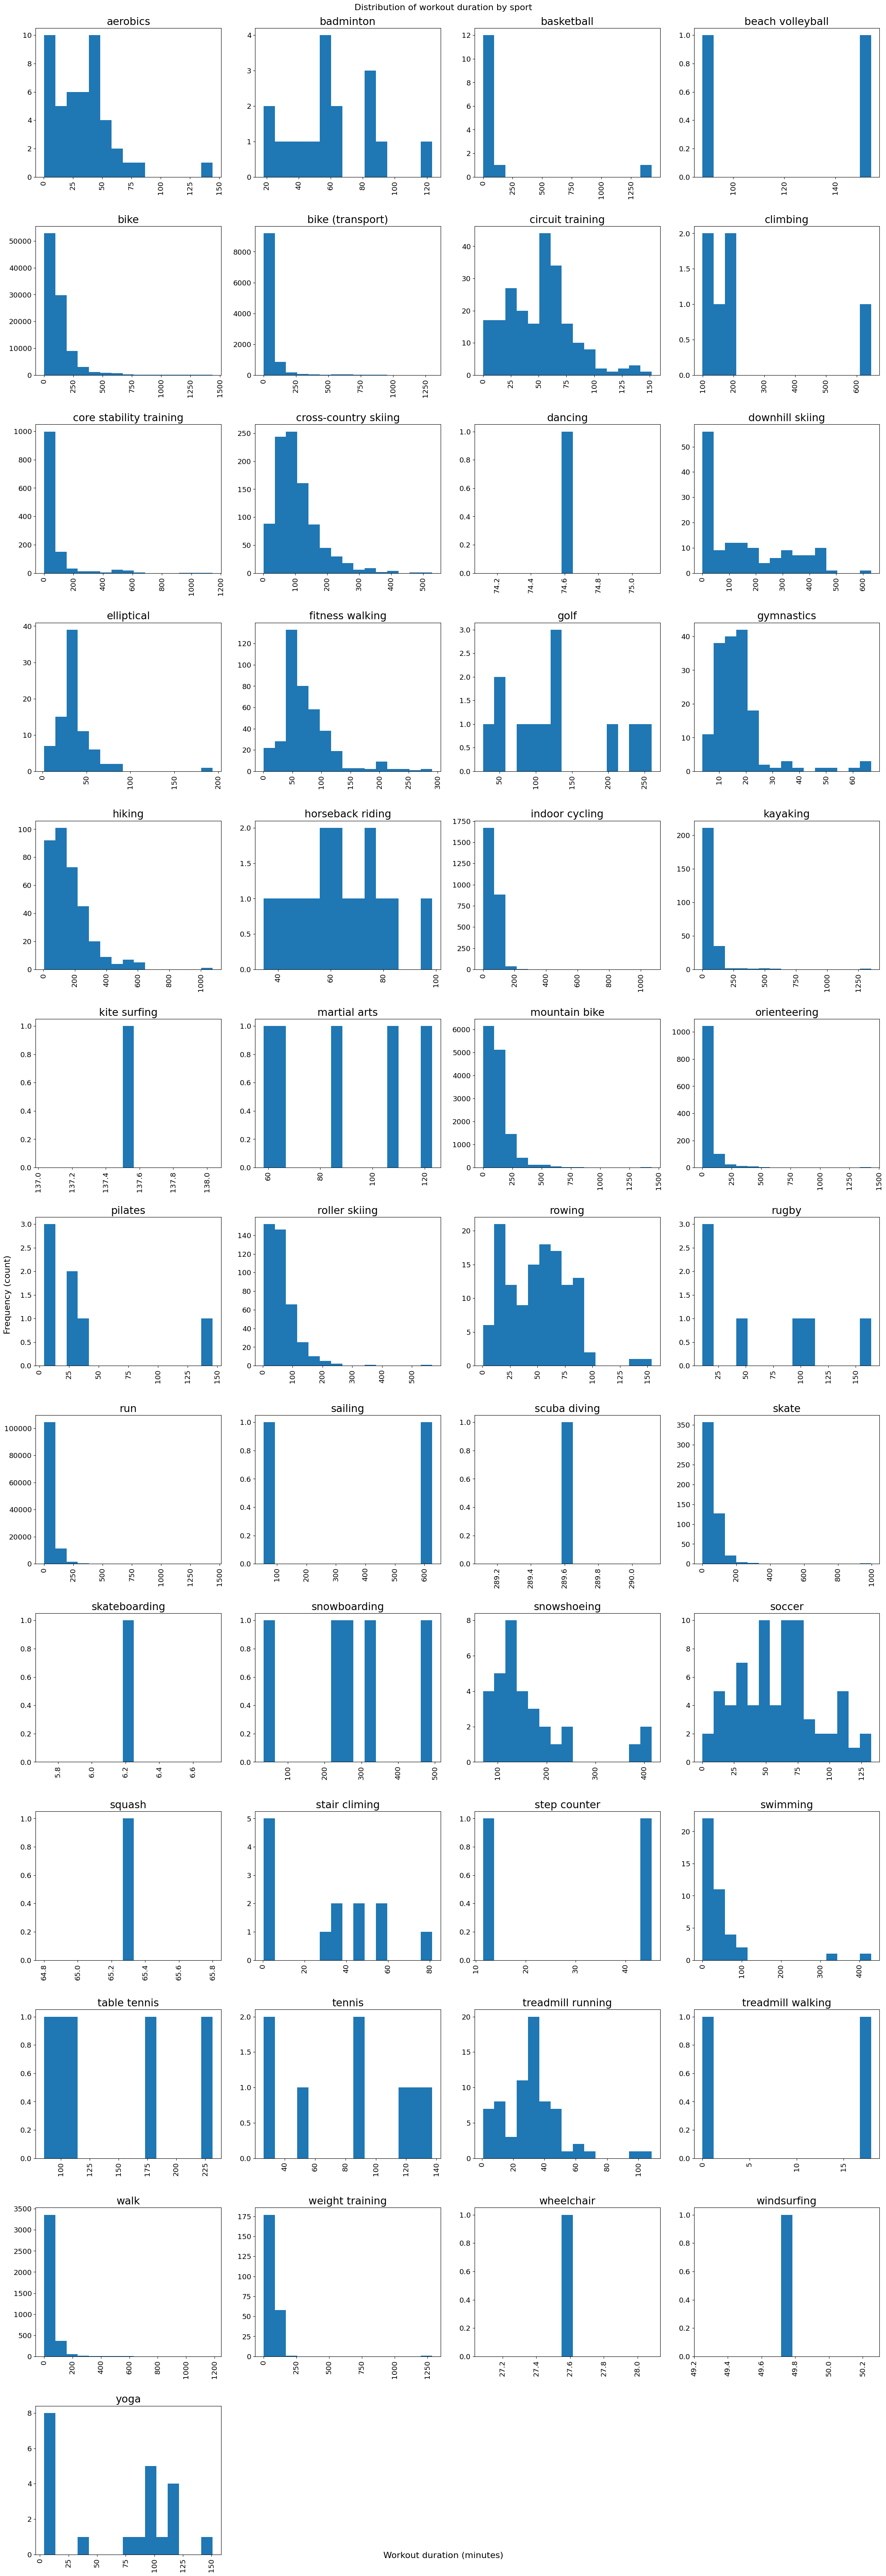

In [32]:
# Plot time for duration
print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5
fig_size_x, fig_size_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize = (fig_size_x, fig_size_y)
fig = plt.figure(figsize=figsize)
grid_size = (13, 4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex=False, grid=True,
    xlabelsize='small', ylabelsize='small', ax=ax, layout=grid_size,
    figsize=figsize
)
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of workout duration by sport',
                 ha='center', va='center', transform=fig.transFigure)
xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)',
                  ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)',
                  va='center', rotation='vertical')

From the duration summary & distribution plot, majority of the activities happens in 1-2 hours, only a few sports with a few cases each type happened in longer durations, such as moutain bike, hiking, sailing, etc.

# ***8. Convert row objects to Spark Resilient Distributed Dataset ([RDD](https://www.databricks.com/glossary/what-is-rdd))***

In this plot, we will practice how to convert the row object to RDD format in Pyspark through:

In [33]:
"""
rdd = df.rdd.map(tuple)
OR
rdd = df.rdd.map(list)
"""


'\nrdd = df.rdd.map(tuple)\nOR\nrdd = df.rdd.map(list)\n'

RDD format: Each data set is divided into logical parts and these can be easily computed on different nodes of the cluster. They can be operated in parallel and are fault-tolerant, so that the process is stable and very fast.

If we run this code such as on Zeppelin which integrated with Pyspark clusters,
we can see how speedy RDD spark is.

To practice, we will look at the *interval* column and have some statistics for it. We will calculate some major statistics info in Pyspark, convert to RDD, and plot.

In [34]:
# Helper function to calculate statistics of the
# column name from a tuple x of (sport, records list of the column)

# The stats to calculate is also given as an input
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
  return a

def extend(a, b):
  a.extend(b)
  return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by sports
    sport_record_rdd = df.select('sport', column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect())

    # Set proper dataframe column orders
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # re-order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
             '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df,
                                                       column_name='interval',
                                                       stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport): ')
interval_statistic_df


Let's look at statistic for interval, in seconds (by sport): 


sport  min interval  25th percentile interval  \
0                      walk             0                       3.0   
1         treadmill running             0                       2.0   
2                      yoga             0                       3.0   
3          bike (transport)             0                       3.0   
4                    soccer             0                       4.0   
5                  kayaking             0                       5.0   
6                      bike             0                       5.0   
7                    rowing             0                       4.0   
8                      golf             0                       6.0   
9                    squash             2                       6.0   
10             snowboarding             1                      11.0   
11         beach volleyball             0                      12.0   
12                      run             0                       4.0   
13                  pilates             1                       3.0   
14                   tennis             1                       5.0   
15             table tennis             1                       8.0   
16            skateboarding             1                       1.0   
17            stair climing             0                       3.0   
18               gymnastics             0                       1.0   
19            roller skiing             0                       3.0   
20             kite surfing            16                      16.0   
21             step counter             1                       7.0   
22             scuba diving            10                      21.0   
23              windsurfing             3                       3.0   
24               wheelchair             1                       4.0   
25        treadmill walking             0                       2.0   
26                  sailing             1                       6.0   
27               elliptical             0                       3.0   
28          weight training             0                       3.0   
29                 climbing             3                      14.0   
30          downhill skiing             0                       6.0   
31             orienteering             0                       5.0   
32                  dancing             2                      20.0   
33                 swimming             1                       3.0   
34     cross-country skiing             0                       6.0   
35                badminton             0                       4.0   
36             martial arts             0                       6.0   
37          fitness walking             0                       5.0   
38               basketball             1                       3.0   
39         horseback riding             0                       4.0   
40           indoor cycling             0                       5.0   
41         circuit training             0                       3.0   
42                 aerobics             0                       3.0   
43                    rugby             1                       3.0   
44                   hiking             0                       8.0   
45              snowshoeing             1                       9.0   
46            mountain bike             0                       6.0   
47  core stability training             0                       3.0   
48                    skate             0                       3.0   

    mean interval  50th percentile interval  75th percentile interval  \
0        7.912633                       5.0                      8.00   
1        5.513624                       4.0                      6.00   
2       18.114438                       7.0                     19.00   
3        8.529853                       5.0                      8.00   
4        7.579923                       6.0                      9.00   
5       11.859714                

Now we plot those numbers in bar (for quantities statistics) and line chart (for/min/max/stdev) for a more visualized feel.

Note: *Due to the fact that the maximum interval and stdev have a much higher order of magnitutde compared to the remaining columns, we need to put those 2 columns in a seperate y axis on the right.*


Summarize statistics of interval sport:


<ipython-input-35-400db1c724c8>:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  a = tick.label.set_fontsize(16)
<ipython-input-35-400db1c724c8>:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  a = tick.label.set_fontsize(16)
<ipython-input-35-400db1c724c8>:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  a = tick.label.set_fontsize(16)
<ipython-input-35-400db1c724c8>:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  a = tick.label.set_fontsize(16)
<ipython-input-35-400db1c724c8>:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  a = tic

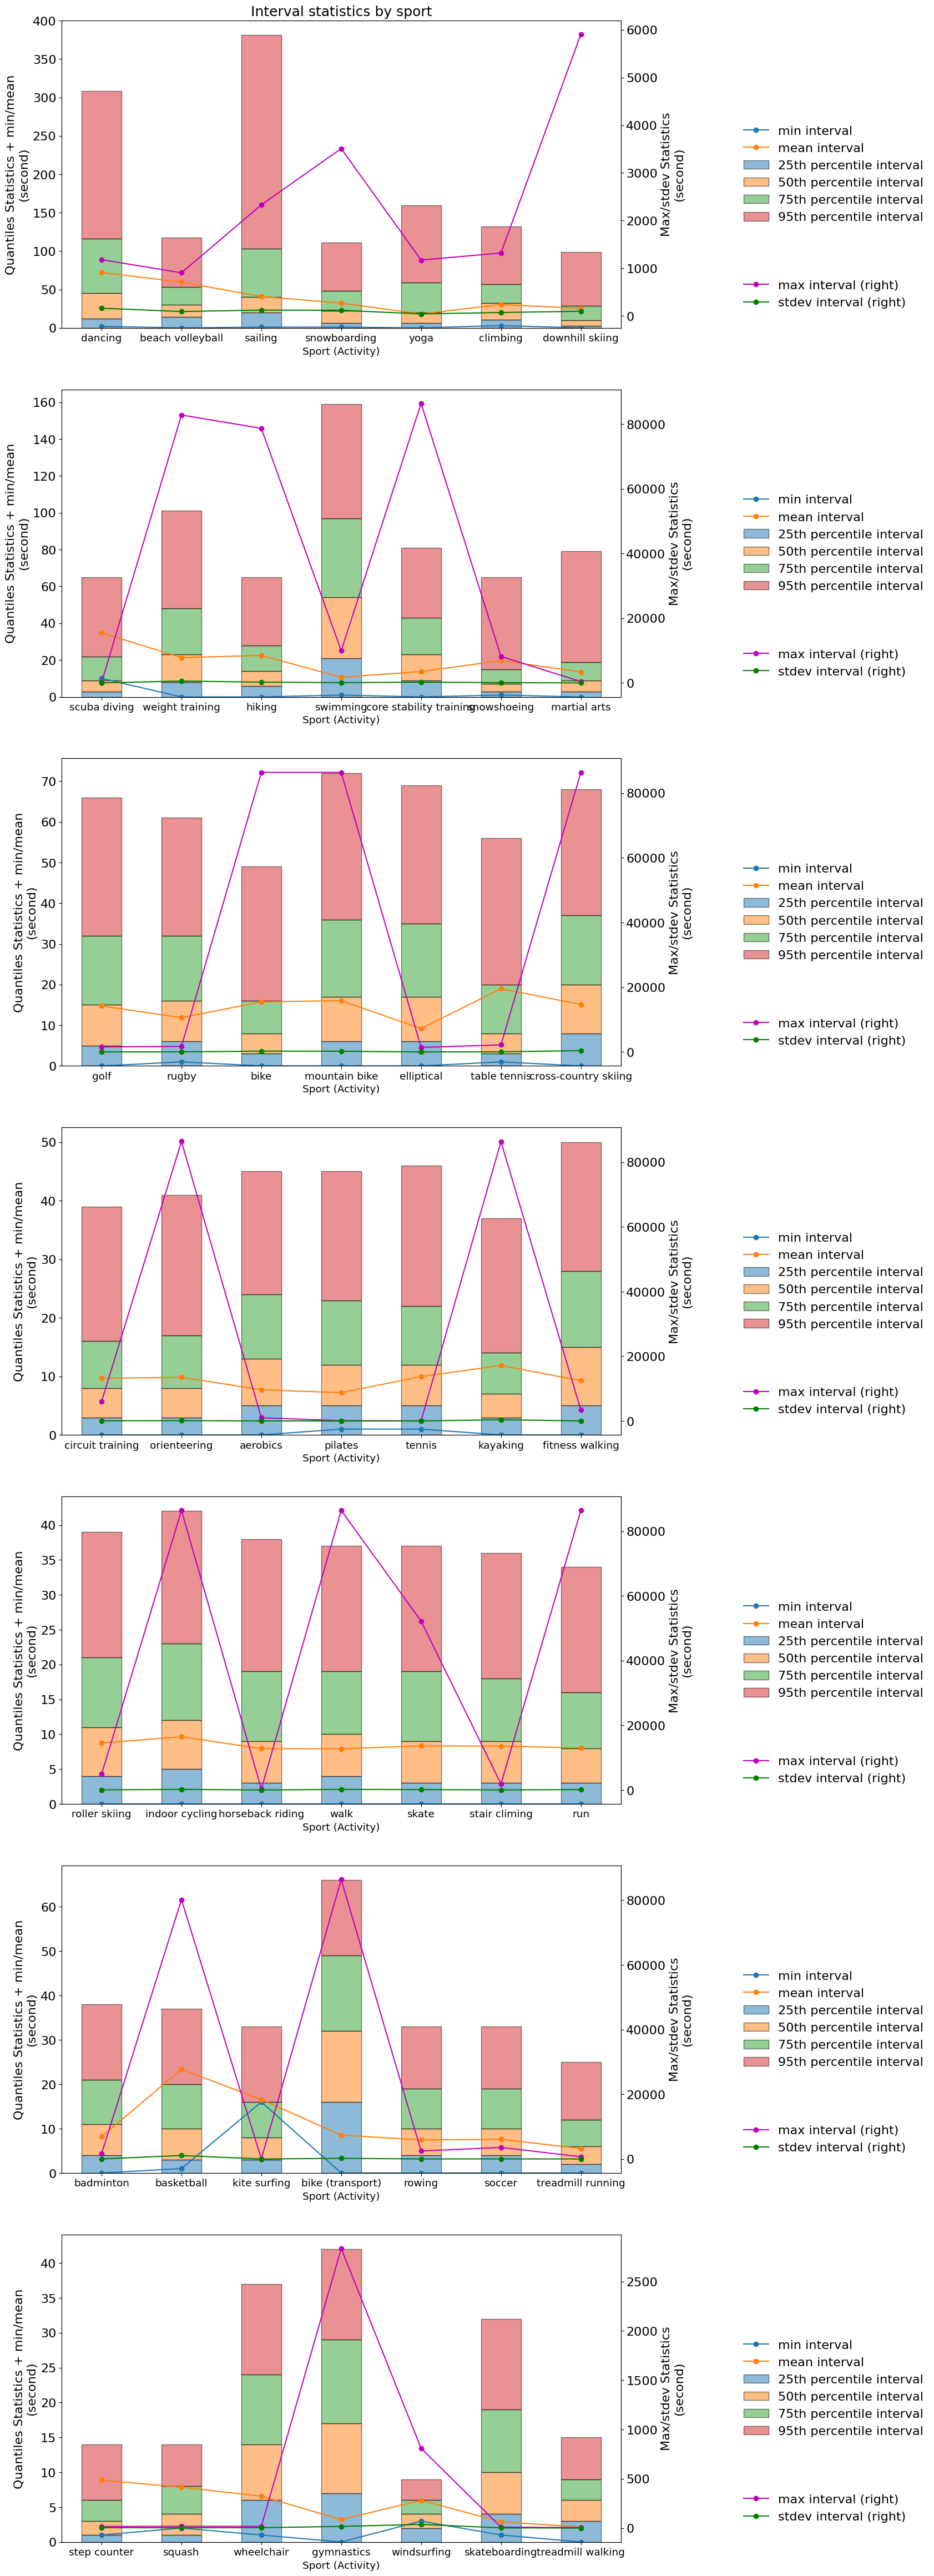

In [35]:
print('\nSummarize statistics of interval sport:')
bar_columns = ['25th percentile interval', '50th percentile interval'
               , '75th percentile interval', '95th percentile interval']
line_columns1 = ['min interval', 'mean interval']
line_columns2 = ['max interval', 'stdev interval']
interval_statistic_df = interval_statistic_df.sort_values(
    by='95th percentile interval', ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('Interval statistics by sport', fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[['sport'] + bar_columns] \
        .groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5,
        edgecolor='black', ax=axs[i],
    )
    plot2 = interval_statistic_sub_df[['sport'] + line_columns1].plot(
        x='sport', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[['sport'] + line_columns2].plot(
        x='sport', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df['sport'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label.set_fontsize(16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)
plt.show();

Looking at the quantile statistics, up to 95% of the interva; data set does not have an interval larger than 400 seconds, while there are a few outliers that made the maximum intervals reach up to 86400 seconds (full days)

**Workout start time**

Once again, we use a histogram chart to look at the distribution of workouts' started hours, grouped by sport and broken down by gender. We divided a day into intervals of 2 hours, so there are totally 12 buckets.

In [36]:
# Retrieve the table of gender, sport, and workout_start_time for plotting
start_time_df = df.select('gender','sport','workout_start_time').toPandas()


Plotting distribution of workout start time per sport type,                                               broken down by gender


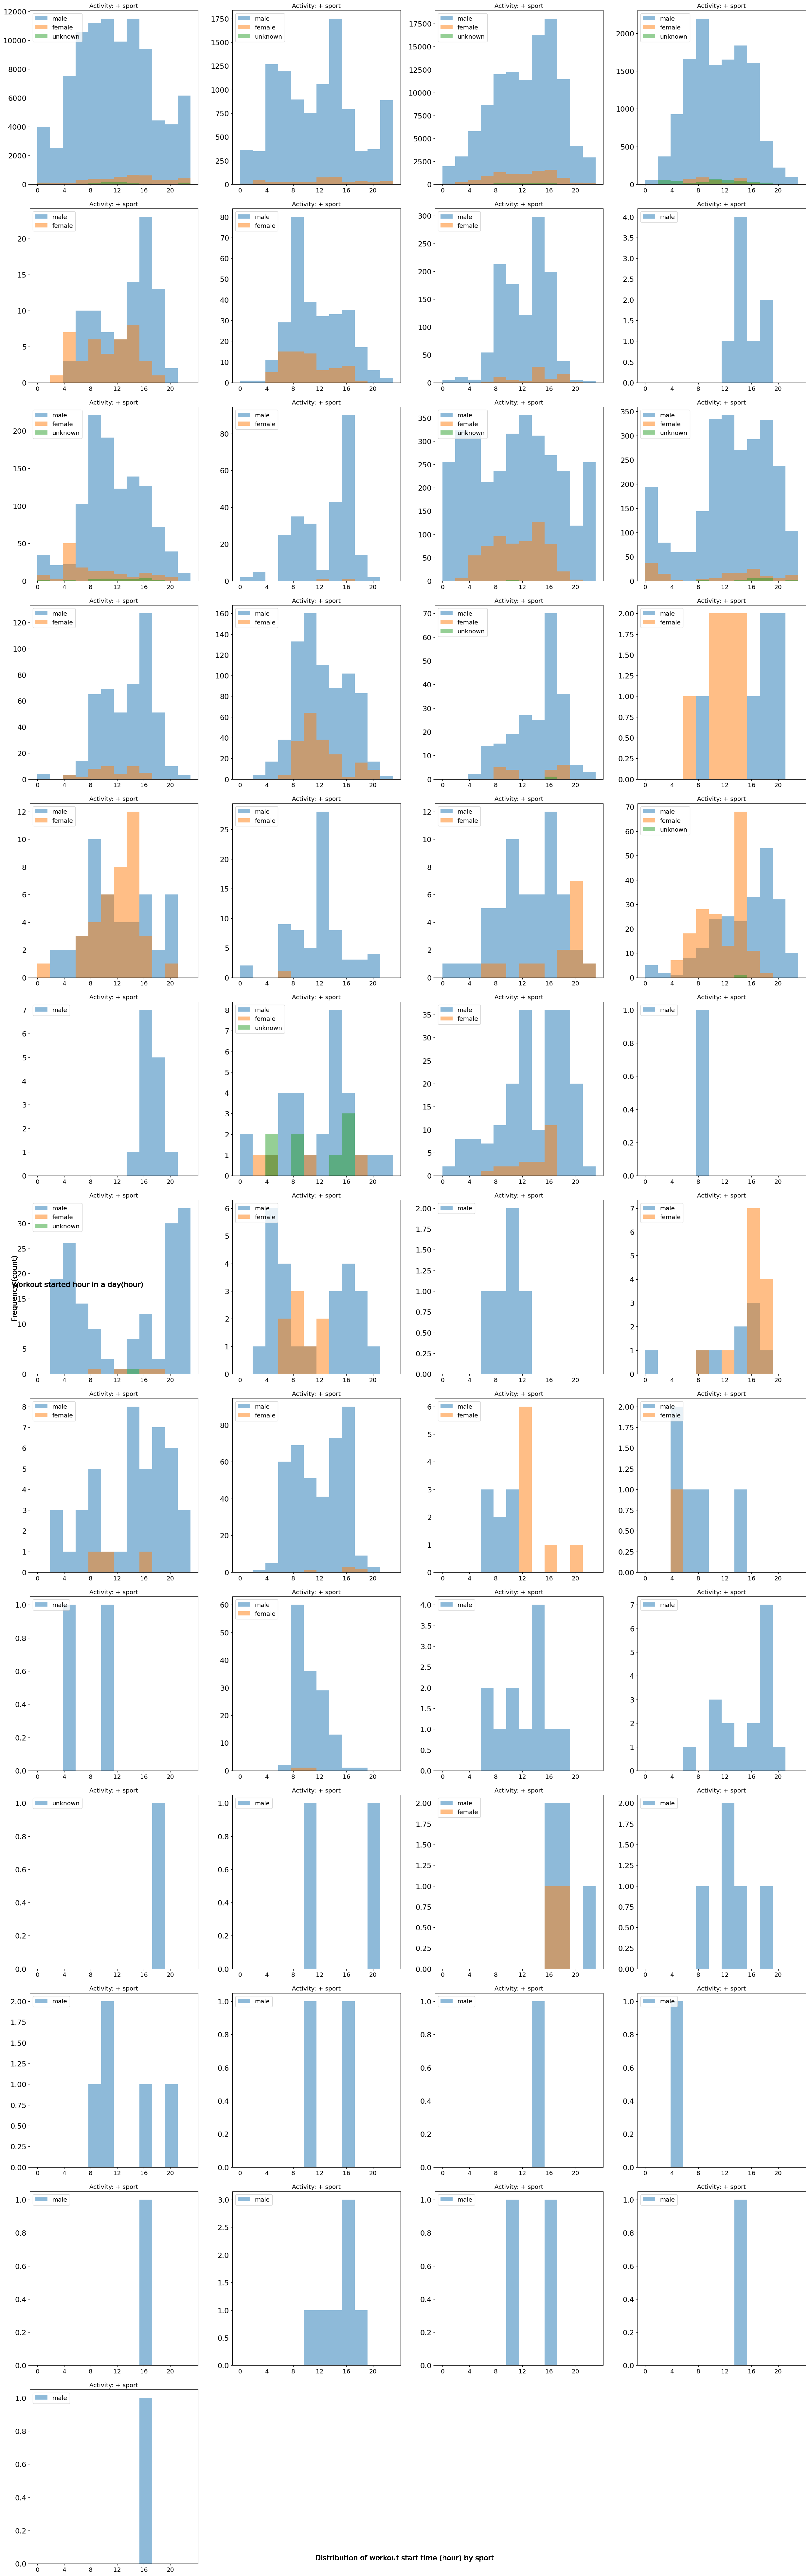

In [37]:
activities = start_time_df['sport'].unique()
plot_size_x, plot_size_y = 5, 5
fig_size_x, fig_size_y = (plot_size_x+0.5) * 4+3, (plot_size_y+1) *13+1

nrows, ncols = 13, 4
a = fig.subplots_adjust(hspace=1, wspace=1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(fig_size_x, fig_size_y))
print('\nPlotting distribution of workout start time per sport type, \
                                              broken down by gender')
a = plt.setp(axs, xticks=[0, 4, 8, 12, 16, 20])
for index, sport in enumerate(activities):
  row_index, col_index = divmod(index, ncols)
  male_start_time_list = start_time_df[(start_time_df.sport == sport) &
                                       (start_time_df.gender == 'male')]['workout_start_time']
  female_start_time_list = start_time_df[(start_time_df.sport == sport) &
                                         (start_time_df.gender == 'female')]['workout_start_time']
  unknown_start_time_list = start_time_df[(start_time_df.sport == sport) &
                                          (start_time_df.gender == 'unknown')]['workout_start_time']
  if len(male_start_time_list) > 0:
    male_dist = axs[row_index, col_index].hist(
        male_start_time_list, bins=12, alpha=0.5, label='male',
        range=(0, 23))
  if len(female_start_time_list) > 0:
    female_dist = axs[row_index, col_index].hist(
        female_start_time_list, bins=12, alpha=0.5, label='female',
        range=(0, 23))
  if len(unknown_start_time_list) > 0:
    unknown_dist = axs[row_index, col_index].hist(
        unknown_start_time_list, bins=12, alpha=0.5, label='unknown',
        range=(0, 23)
    )
  b = axs[row_index, col_index].set_title('Activity: + sport', fontsize='small')
  a = axs[row_index, col_index].legend(loc='upper left', fontsize='small')
  a = plt.setp(axs[row_index, col_index].get_xticklabels(), fontsize='small')
  for i in range(1, 4):
    a = axs[12, i].set_visible(False)
  a = fig,plt.tight_layout()
  z = fig.text(0.5, 0.01, 'Distribution of workout start time (hour) by sport',
               ha='center', va='top', transform=fig.transFigure)
  y = fig.text(0.02, 0.5, 'Workout started hour in a day(hour)', va='bottom',
               transform=fig.transFigure)
  z = fig.text(0.02, 0.5, 'Frequency (count)', va='center', rotation='vertical')


From the distribution charts above, it can be seen that most of the sports have activities started either in the morning or evening (bimodial distribution), which does make sense. There are few activities happening during the timeframe of 0-4 o'clock, which is quite odd.

**Look deeper into row information**

In [38]:
stat_list = ['min', '25th percentile', 'mean', '95th percentile',
             'max', 'stdev']
heart_rate_statistics_df = retrieve_array_column_stat_df(
    df, column_name='heart_rate', stat_list=stat_list
)

Due to a huge amount of users and workout numbers, we just picked randomly, up to aa x of users per gender (ex, 5) and up to y workouts per activity type (ex, 10).

In [48]:
# Support function for sample data
def sampling_data(max_users_per_gender, max_workouts_per_sport):
  '''
  max_users_per_gender: maximum number of users to be selected
  randomly per gender
  max_workouts_per_sport: maximum number of activities to be selected
  per sport
  (the sports existing in selected users)
  '''
  # Get unique list of userId and gender, for sampling purpose
  users_genders = df.select('userId', 'gender').distinct().toPandas()
  # Use 'sample' function to pick up to 3 userId per gender from the unique userId list
  random_x_users_per_gender = users_genders.groupby('gender')['userId'].apply(
              lambda s: s.sample(min(len(s), max_users_per_gender))
  )
  # Apply filter on the main pyspark dataframe for sampling
  samples_by_gender = df.where(df.userId.isin(list(random_x_users_per_gender)))

  # Next, generate the unique activity ids and sport types list from the sampled data set
  workout_sports = samples_by_gender.select('id', 'sport').distinct().toPandas()
  # Use 'sample' function to pick up to 10 activity ids for each kind of sport
  random_y_workouts_per_sport = workout_sports.groupby('sport')['id'].apply(
      lambda s: s.sample(min(len(s), max_workouts_per_sport))
  )
  # Apply filter to the sampled dataset to continue reduce the number of workouts per activity type
  samples_by_gender_and_sport = samples_by_gender.where(df.id.isin(list(random_y_workouts_per_sport)))
  return samples_by_gender_and_sport

In [49]:
# Use 2 variables to determine the sample criteria:
# maximum users per gender and maximum workouts per sport
max_users_per_gender, max_workouts_per_sport = 20, 15
# Collect the sampled dataset to Pandas to be used with plot features
pd_df = sampling_data(max_users_per_gender, max_workouts_per_sport).toPandas()

print('\nSampled data overview( only string and numeric columns): ')
pd_df.describe()


Sampled data overview( only string and numeric columns): 


id        userId  PerWorkoutRecordCount  workout_start_time  \
count  2.140000e+02  2.140000e+02             214.000000          214.000000   
mean   3.484517e+08  3.287246e+06             417.500000           10.878505   
std    1.657594e+08  2.923784e+06             146.267257            5.282108   
min    1.137270e+07  1.417940e+05               2.000000            0.000000   
25%    2.195832e+08  1.663599e+06             391.250000            7.000000   
50%    3.292127e+08  2.071522e+06             500.000000           11.000000   
75%    4.522472e+08  4.439016e+06             500.000000           15.000000   
max    6.525451e+08  1.204962e+07             500.000000           23.000000   

         duration  
count  214.000000  
mean    70.781387  
std     76.844574  
min      0.016667  
25%     31.495833  
50%     51.933334  
75%     83.325001  
max    568.883362

We will normalize the time for all workouts by calculating the duration (in seconds) of each timestamp record from the first record of a workout (the first datetime element of the list in that workout). Then we plot the heart rate on this normalized time, grouping by sport.

New normalized datetime (first 7 rows): 


userId   sport                                          date_time  \
0  279317  hiking  [2014-07-01 04:22:16, 2014-07-01 04:23:26, 201...   
1  279317  rowing  [2014-06-16 14:03:31, 2014-06-16 14:03:37, 201...   
2  279317  rowing  [2014-05-29 09:45:17, 2014-05-29 09:45:21, 201...   
3  279317  rowing  [2014-05-28 13:13:11, 2014-05-28 13:13:21, 201...   
4  279317  rowing  [2014-05-19 04:18:44, 2014-05-19 04:19:22, 201...   
5  279317  rowing  [2014-05-16 04:05:45, 2014-05-16 04:05:54, 201...   
6  279317  rowing  [2014-05-10 10:58:56, 2014-05-10 10:59:59, 201...   

                                normalized_date_time  
0  [0, 70, 138, 198, 258, 319, 384, 445, 508, 572...  
1  [0, 6, 12, 21, 27, 32, 38, 48, 54, 61, 68, 77,...  
2  [0, 4, 7, 14, 17, 21, 27, 30, 33, 38, 40, 43, ...  
3  [0, 10, 19, 26, 34, 41, 45, 51, 63, 71, 84, 93...  
4  [0, 38, 51, 62, 71, 80, 86, 95, 109, 120, 132,...  
5  [0, 9, 18, 26, 37, 47, 54, 68, 78, 90, 103, 11...  
6  [0, 63, 123, 183, 245, 305, 365, 426, 524, 569...


Plot raw heart rate (sampled) by normalized time:


<ipython-input-51-1a55ab275f60>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  xstixklabels_i = axs[sport_index].set_xticklabels(


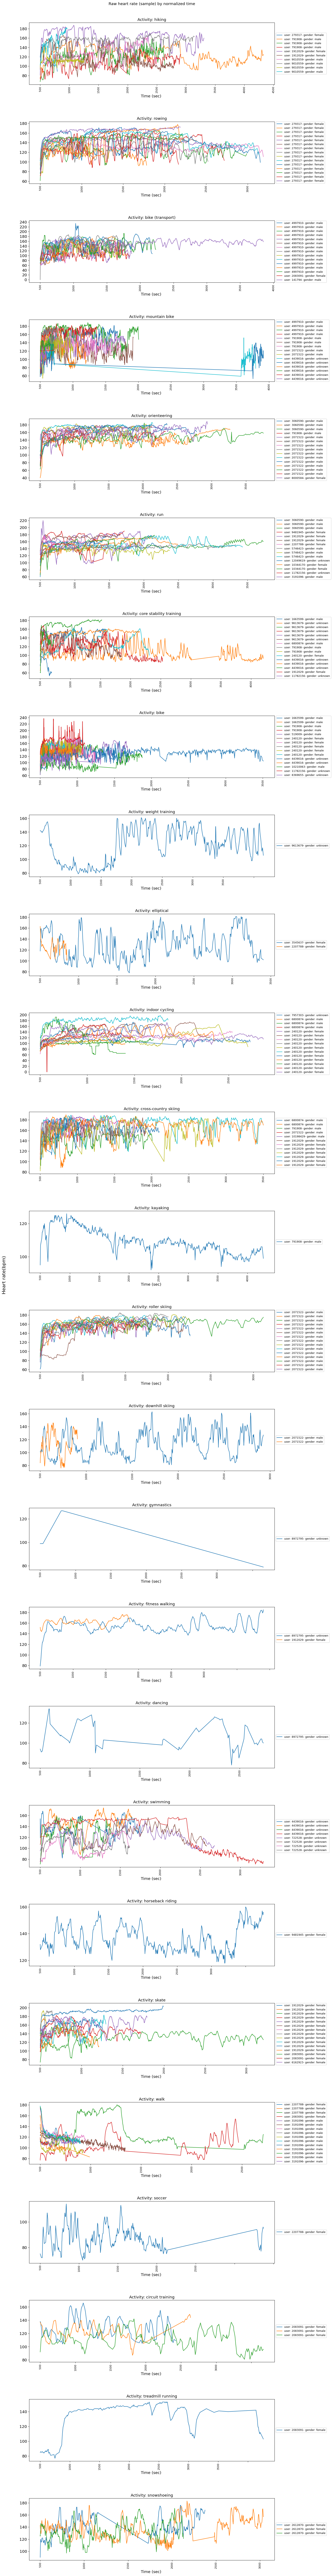

In [51]:
# Lambda function to flatten a list of list into a big simgle list
flattern = lambda l: set([item for sublist in l for item in sublist])

normalized_datetime_list = []
for index, data_row in pd_df.iterrows():
  min_date_time = min(data_row['date_time'])
  normalized_datetime_list.append(
      [(date_time - min_date_time).seconds for date_time in data_row['date_time']]
  )

pd_df['normalized_date_time'] = normalized_datetime_list

print('New normalized datetime (first 7 rows): ')
pd_df.head(7)[['userId','sport','date_time','normalized_date_time']]

print('\nPlot raw heart rate (sampled) by normalized time:')

sport_list = pd_df['sport'].unique()
# Define the length of the figure dynamically depends on the length of the sport list
fig, axs = plt.subplots(len(sport_list), figsize=(15, 6*len(sport_list)))
subplot_adj = fig.subplots_adjust(hspace=0.6)
plot_setp = plt.setp(axs, yticks=range(0, 250, 20))

for sport_index, sport  in enumerate(sport_list):
  workout = pd_df[pd_df.sport == sport]
  max_time = max(flattern(workout.normalized_date_time))
  for workout_index, data_row in workout.iterrows():
    label = 'user: ' + str(data_row['userId']) + '- gender: ' + data_row['gender']
    plot_i = axs[sport_index].plot(
        data_row['normalized_date_time'], data_row['heart_rate'], label=label
    )
  title_i = axs[sport_index].set_title('Activity: ' + sport, fontsize='small')
  xlabel_i = axs[sport_index].set_xlabel('Time (sec) ', fontsize='small')
  xstixklabels_i = axs[sport_index].set_xticklabels(
      range(0, max_time, 500), rotation = 'vertical', fontsize=9
  )
  ysticklabels_i = axs[sport_index].set_yticklabels(range(0, 250, 20),
                                                    fontsize='small')
  legend_i = axs[sport_index].legend(
      loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 9}
  )

x_label = fig.text(0.04, 0.5, 'Heart rate(bpm)',
                   va='center', rotation='vertical')
chart_title = fig.text(0.5, 1.3, 'Raw heart rate (sample) by normalized time',
                       ha='center', va='center', fontsize='small',
                       transform=axs[0].transAxes)


**Work Displacements**
We will have some visualiztations on 3 displacement/geometry info columns (longitude, latitude & altitude).
Since the geometry location of each user and workout is different from each other, we only plot a few single workouts in 3D plots to have a look on the workout rate.

In [52]:
pd_df_small = sampling_data(max_users_per_gender=2,
                            max_workouts_per_sport=2).toPandas()

print('Sampled data (2 users, 2 workouts per sport): ')
pd_df_small[['userId','gender','sport','id','workout_start_time',
             'PerWorkoutRecordCount','duration', 'longitude',
             'latitude', 'altitude']].describe()

Sampled data (2 users, 2 workouts per sport): 


userId            id  workout_start_time  PerWorkoutRecordCount  \
count  2.500000e+01  2.500000e+01           25.000000              25.000000   
mean   3.941660e+06  3.096846e+08           12.560000             404.440000   
std    2.757700e+06  1.702471e+08            3.863073             159.661381   
min    8.975920e+05  5.430028e+07            5.000000              27.000000   
25%    1.912029e+06  1.785580e+08            9.000000             257.000000   
50%    3.556695e+06  2.777297e+08           14.000000             500.000000   
75%    3.556695e+06  3.572778e+08           16.000000             500.000000   
max    9.613679e+06  6.396734e+08           18.000000             500.000000   

         duration  
count   25.000000  
mean    82.150665  
std     81.805771  
min      0.983333  
25%     49.866665  
50%     60.016666  
75%     86.933334  
max    396.166656